### Basic Chatbot with langgraph (Graph API)

In [3]:
from typing import Annotated 

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages


In [4]:
class State(TypedDict): 
    messages: Annotated[list,add_messages] #add_messages is a reducer that appends messages to the list rather than overwriting it 

graph_builder=StateGraph(State) 

In [5]:
graph_builder

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [8]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000024F689CAB90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024F677272D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000024F69A6E290>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024F69A6EE90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
def chatbot(state: State): 
    return {"messages":[llm.invoke(state['messages'])]}

In [11]:
graph_builder=StateGraph(State)
graph_builder.add_node("chat",chatbot)
graph_builder.add_edge(START,"chat")
graph_builder.add_edge("chat",END)
app=graph_builder.compile()

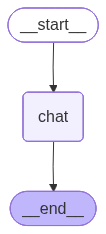

In [12]:
app

In [13]:
response=app.invoke({"messages":"Hi there!, I am Yeswanth"})

In [14]:
response["messages"][-1].content

"Nice to meet you, Yeswanth. How can I assist you today? Do you have any specific questions or topics you'd like to discuss?"

In [15]:
for event in app.stream({"messages":"Hello, how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm functioning properly, thank you for asking. I'm a large language model, so I don't have emotions or feelings in the same way that humans do, but I'm here to help you with any questions or information you might need. How can I assist you today?


### Chatbot with tools

In [16]:
from langchain_tavily import TavilySearch 

tool=TavilySearch(max_results=2) 
tool.invoke("What are the latest advancements in AI?")

{'query': 'What are the latest advancements in AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
   'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025',
   'content': 'Summary: DeepCogito v2, an open-source AI model, has been released with improved logical reasoning and task planning. Developers say it outperforms many closed',
   'score': 0.7371019,
   'raw_content': None},
  {'url': 'https://ep.jhu.edu/news/advancements-in-ai-and-machine-learning/',
   'title': 'Advancements in AI and Machine Learning',
   'content': 'Advances in ML, natural language processing (NLP), and computer vision have enabled AI to perform ever-more complex tasks such as diagnosing',
   'score': 0.7060491,
   'raw_content': None}],
 'response_time': 0.82,
 'request_id': '4f213e86-3a99-40cf-b06b-2a18c0e3065d'}

In [27]:
def multiply(a:int,b:int)->int: 
    """Multiple a and b
    Args:
        a (int): The first number
        b (int): The second number
    Returns:
        int: output int
    """
    return a*b
    

In [28]:
tools=[tool,multiply] 

In [29]:
llm_with_tools=llm.bind_tools(tools)

In [30]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000024F69A6E290>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024F69A6EE90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input sho

In [31]:
# State Graph with Tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition 

def tool_calling_llm(state:State): 
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder=StateGraph(State) 
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools)) 


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

app_with_tools=builder.compile()

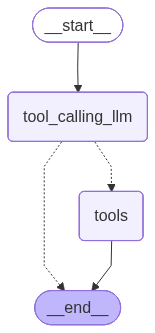

In [32]:
app_with_tools

In [33]:
app_with_tools.invoke({"messages":"Can you multiply 12 and 15 for me?"})

{'messages': [HumanMessage(content='Can you multiply 12 and 15 for me?', additional_kwargs={}, response_metadata={}, id='36102064-ece9-4227-9baa-e4f18d6f0c9a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nsm1g45q9', 'function': {'arguments': '{"a":12,"b":15}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1804, 'total_tokens': 1823, 'completion_time': 0.032579246, 'completion_tokens_details': None, 'prompt_time': 0.127333961, 'prompt_tokens_details': None, 'queue_time': 0.052185658, 'total_time': 0.159913207}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c09e0-f065-7581-9752-de13116910b8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 12, 'b': 15}, 'id': 'nsm1g45q9', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_to

In [36]:
response=app_with_tools.invoke({"messages":"what is the latest research in artificial intelligence?"})
response["messages"][-1].content

'{"query": "latest research in artificial intelligence", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nature.com/articles/s41698-026-01276-6", "title": "The impact of AI on modern oncology from early detection to personalized cancer treatment - Nature", "score": 0.6364215, "published_date": "Sat, 24 Jan 2026 00:00:00 GMT", "content": "Google Scholar\\n6. Geéron A. Hands-on Machine Learning with Scikit-Learn and Tensor Flow: Concepts, Tools, and Techniques to Build Intelligent Systems (E-book, O’Reilly, 2017).\\n7. Basu, K., Sinha, R., Ong, A. & Basu, T. Artificial intelligence: how is it changing medical sciences and its future? Indian J. Dermatol. 65, 365–370 (2020).\\n\\n   Google Scholar\\n8. Xu, Y. et al. Artificial intelligence: a powerful paradigm for scientific research. Innovation 2, 100179 (2021).\\n\\n   Google Scholar\\n9. Rajpurkar, P., Chen, E., Banerjee, O. & Topol, E. J. AI in health and medicine. Nat. Med. 28, 31–38 (2022).

In [37]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the latest research in artificial intelligence?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (va38ggfny)
 Call ID: va38ggfny
  Args:
    query: latest research in artificial intelligence
    search_depth: advanced
    start_date: None
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest research in artificial intelligence", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nature.com/articles/s41698-026-01276-6", "title": "The impact of AI on modern oncology from early detection to personalized cancer treatment - Nature", "score": 0.6364215, "published_date": "Sat, 24 Jan 2026 00:00:00 GMT", "content": "Google Scholar\n6. Geéron A. Hands-on Machine Learning with Scikit-Learn and Tensor Flow: Concepts, Tools, and

In [38]:
response=app_with_tools.invoke({"messages":"what is the product of 25 and 4?"})
response["messages"][-1].content

'100'

In [39]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the product of 25 and 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (brfyy30y0)
 Call ID: brfyy30y0
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: multiply

100


In [40]:
response=app_with_tools.invoke({"messages":"what is the product of 25 and 4 and multiply that by 3?"})
response["messages"][-1].content

'300'

In [41]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the product of 25 and 4 and multiply that by 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (kxymeky55)
 Call ID: kxymeky55
  Args:
    a: 25
    b: 4
  multiply (p78fzk70e)
 Call ID: p78fzk70e
  Args:
    a: 100
    b: 3
================================= Tool Message =================================
Name: multiply

100
================================= Tool Message =================================
Name: multiply

300


In [42]:
response=app_with_tools.invoke({"messages":"what is the recent ai news and multiply 5 by 3?"})
response["messages"][-1].content

'15'

In [43]:
for i in response['messages']:
    i.pretty_print()

================================ Human Message =================================

what is the recent ai news and multiply 5 by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7kdavan14)
 Call ID: 7kdavan14
  Args:
    query: recent AI news
    topic: news
  multiply (42sph93w7)
 Call ID: 42sph93w7
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2026/01/22/google-now-offers-free-sat-practice-exams-powered-by-gemini/", "title": "Google now offers free SAT practice exams, powered by Gemini - TechCrunch", "score": 0.9785493, "published_date": "Thu, 22 Jan 2026 18:27:36 GMT", "content": "# Google now offers free SAT practice exams, powered by Gemini. The company announced that it’s now focusing its AI education efforts 